<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/test_training_ST_on_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Training NN model(s) on theoretical data generated via the simple physical model

In [2]:
!pip install lmfit
#!pip install seaborn

In [3]:
import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """
    if phi<=np.pi/2:
        theta=np.pi/2-phi
    else:
        theta=2.5*np.pi-phi
    return theta


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

2.5.0
Num GPUs Available:  0


Check the connection to google's **GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Generate data based on experimental data

Run the next code box only if google drive is not mounted to colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/')

# fileSDS1=pd.read_csv(str(path+'SDS/SDS_conci_0.01054_all.csv'), sep="\t", header=None)
# fileSDS2=pd.read_csv(str(path+'SDS/SDS_conci_0.02108_all.csv'), sep='\t', header=None)
# fileSDS3=pd.read_csv(str(path+'SDS/SDS_conci_0.04273_all.csv'), sep='\t', header=None)
# fileSDS4=pd.read_csv(str(path+'SDS/SDS_conci_0.08828_all.csv'), sep="\t", header=None)
# fileSDS5=pd.read_csv(str(path+'SDS/SDS_conci_0.25000_all.csv'), sep="\t", header=None)
# fileSDS6=pd.read_csv(str(path+'SDS/SDS_conci_0.50000_all.csv'), sep="\t", header=None)
# fileSDS7=pd.read_csv(str(path+'SDS/SDS_conci_0.75000_all.csv'), sep="\t", header=None)
# fileSDS8=pd.read_csv(str(path+'SDS/SDS_conci_1.00000_all.csv'), sep="\t", header=None)
# fileSDS9=pd.read_csv(str(path+'SDS/SDS_conci_1.25000_all.csv'), sep="\t", header=None)
# fileSDS10=pd.read_csv(str(path+'SDS/SDS_conci_1.50000_all.csv'), sep="\t", header=None)
# fileSDS11=pd.read_csv(str(path+'SDS/SDS_conci_2.00000_all.csv'), sep="\t", header=None)
# fileSDS12=pd.read_csv(str(path+'SDS/SDS_conci_2.50000_all.csv'), sep="\t", header=None)
# fileSDS13=pd.read_csv(str(path+'SDS/SDS_conci_3.00000_all.csv'), sep="\t", header=None)
# fileSDS14=pd.read_csv(str(path+'SDS/SDS_conci_3.50000_all.csv'), sep="\t", header=None)
# fileSDS15=pd.read_csv(str(path+'SDS/SDS_conci_4.00000_all.csv'), sep="\t", header=None)
# fileSDS16=pd.read_csv(str(path+'SDS/SDS_conci_4.50000_all.csv'), sep="\t", header=None)
# fileSDS17=pd.read_csv(str(path+'SDS/SDS_conci_5.50000_all.csv'), sep="\t", header=None)
# fileSDS18=pd.read_csv(str(path+'SDS/SDS_conci_6.50000_all.csv'), sep="\t", header=None)
# fileSDS19=pd.read_csv(str(path+'SDS/SDS_conci_7.50000_all.csv'), sep="\t", header=None)
# fileSDS20=pd.read_csv(str(path+'SDS/SDS_conci_8.50000_all.csv'), sep="\t", header=None)
# fileSDS21=pd.read_csv(str(path+'SDS/SDS_conci_24.75900_all.csv'), sep="\t", header=None)

# fileTrit1=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00250_all.csv'), sep="\t", header=None)
# fileTrit2=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00500_all.csv'), sep="\t", header=None)
# fileTrit3=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00750_all.csv'), sep="\t", header=None)
# fileTrit4=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01000_all.csv'), sep="\t", header=None)
# fileTrit5=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01500_all.csv'), sep="\t", header=None)
# fileTrit6=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02000_all.csv'), sep="\t", header=None)
# fileTrit7=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02500_all.csv'), sep="\t", header=None)
# fileTrit8=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.03500_all.csv'), sep="\t", header=None)
# fileTrit9=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.05000_all.csv'), sep="\t", header=None)
# fileTrit10=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.07500_all.csv'), sep="\t", header=None)
# fileTrit11=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.10000_all.csv'), sep="\t", header=None)
# fileTrit12=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.12500_all.csv'), sep="\t", header=None)
# fileTrit13=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.15000_all.csv'), sep="\t", header=None)
# fileTrit14=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.17500_all.csv'), sep="\t", header=None)
# fileTrit15=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.20000_all.csv'), sep="\t", header=None)
# fileTrit16=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.25000_all.csv'), sep="\t", header=None)
# fileTrit17=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.30000_all.csv'), sep="\t", header=None)
# fileTrit18=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.45000_all.csv'), sep="\t", header=None)
# fileTrit19=pd.read_csv(str(path+'TritonX100/TritonX_conci_1.00000_all.csv'), sep="\t", header=None)
# fileTrit20=pd.read_csv(str(path+'TritonX100/TritonX_conci_3.00000_all.csv'), sep="\t", header=None)
# fileTrit21=pd.read_csv(str(path+'TritonX100/TritonX_conci_10.00000_all.csv'), sep="\t", header=None)

# fileCTAB1=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00100_all.csv'), sep="\t", header=None)
# fileCTAB2=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00200_all.csv'), sep="\t", header=None)
# fileCTAB3=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00500_all.csv'), sep="\t", header=None)
# fileCTAB4=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01000_all.csv'), sep="\t", header=None)
# fileCTAB5=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01500_all.csv'), sep="\t", header=None)
# fileCTAB6=pd.read_csv(str(path+'CTAB/CTAB_conci_0.05500_all.csv'), sep="\t", header=None)
# fileCTAB7=pd.read_csv(str(path+'CTAB/CTAB_conci_0.10000_all.csv'), sep="\t", header=None)
# fileCTAB8=pd.read_csv(str(path+'CTAB/CTAB_conci_0.15000_all.csv'), sep="\t", header=None)
fileCTAB9=pd.read_csv(str(path+'CTAB/CTAB_conci_0.20000_all.csv'), sep="\t", header=None)
# fileCTAB10=pd.read_csv(str(path+'CTAB/CTAB_conci_0.25000_all.csv'), sep="\t", header=None)
# fileCTAB11=pd.read_csv(str(path+'CTAB/CTAB_conci_0.30000_all.csv'), sep="\t", header=None)
# fileCTAB12=pd.read_csv(str(path+'CTAB/CTAB_conci_0.40000_all.csv'), sep="\t", header=None)
# fileCTAB13=pd.read_csv(str(path+'CTAB/CTAB_conci_0.50000_all.csv'), sep="\t", header=None)
# fileCTAB14=pd.read_csv(str(path+'CTAB/CTAB_conci_0.60000_all.csv'), sep="\t", header=None)
# fileCTAB15=pd.read_csv(str(path+'CTAB/CTAB_conci_0.70000_all.csv'), sep="\t", header=None)
# fileCTAB16=pd.read_csv(str(path+'CTAB/CTAB_conci_0.80000_all.csv'), sep="\t", header=None)
# fileCTAB17=pd.read_csv(str(path+'CTAB/CTAB_conci_0.85000_all.csv'), sep="\t", header=None)
# fileCTAB18=pd.read_csv(str(path+'CTAB/CTAB_conci_0.90000_all.csv'), sep="\t", header=None)
# fileCTAB19=pd.read_csv(str(path+'CTAB/CTAB_conci_1.00000_all.csv'), sep="\t", header=None)
# fileCTAB20=pd.read_csv(str(path+'CTAB/CTAB_conci_5.00000_all.csv'), sep="\t", header=None)
# fileCTAB21=pd.read_csv(str(path+'CTAB/CTAB_conci_13.15224_all.csv'), sep="\t", header=None)



#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)

In [10]:
# input=np.vstack([fileCTAB9, fileCTAB15])
input=fileCTAB9

In [11]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('phi_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('height')  #900
column_names.append('width')  #901
column_names.append('volume')#902
column_names.append('R_sph')#903
column_names.append('volt')#904
column_names.append('Intensity')#905
column_names.append('time') #906
column_names.append('Power')#907
#column_names.append('Ps')
#column_names.append('Ps_err')
column_names.append('centre_x') #908
column_names.append('centre_y') #909
column_names.append('surfactant_conc') #910
column_names.append('Aspect_Ratio') #911
column_names.append('ST') #912


In [ ]:
raw_dataset

In [14]:
### For one file
raw_dataset = input
raw_dataset.columns=column_names

### For multiple files
# raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()

dataset.centre_y=-dataset.centre_y

# for i in range(300):
#  dataset.pop('rho_%d' %i)
for i in range(300):
  dataset.pop('phi_%d' %i)
# for i in range(300):
#  dataset.pop('theta_%d' %i)
dataset.pop("height")
dataset.pop("width")
# dataset.pop("volume")
# dataset.pop("R_sph")
# dataset.pop('volt')
dataset.pop('Intensity')
dataset.pop('time')
dataset.pop('Power')
# dataset.pop('Ps')
#dataset.pop('Ps_err')
dataset.pop("centre_x")
dataset.pop("centre_y")
dataset.pop('surfactant_conc')
dataset.pop("Aspect_Ratio")


dataset.tail()

#We keep: volume	Power	centre_y	Aspect_Ratio	st

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,R_sph,volt,ST
5024,0.996002,0.996046,0.996528,0.993154,0.993330,0.993945,0.990129,0.989533,0.985300,0.985906,0.986526,0.978083,0.976959,0.973225,0.971832,0.969214,0.966061,0.961180,0.958905,0.955603,0.946831,0.942322,0.932738,0.932668,0.925992,0.921286,0.919775,0.916841,0.908753,0.906298,0.874911,0.871426,0.867565,0.861045,0.848694,0.848652,0.845945,0.826792,0.809850,0.794877,...,-0.895713,-0.925558,-0.972699,-0.978642,-0.990486,-1.002272,-1.010401,-1.016232,-1.022047,-1.039392,-1.067953,-1.073611,-1.090468,-1.101609,-1.112668,-1.143662,-1.163504,-1.174138,-1.192165,-1.216717,-1.248416,-1.266015,-1.360792,-1.373019,-1.380661,-1.385210,-1.421524,-1.448837,-1.484141,-1.495649,-1.503590,-1.526594,-1.534274,-1.538241,-1.545897,-1.565049,3.088455,0.903409,9.9,54.707306
5025,0.996002,0.996046,0.996148,0.996806,0.997331,0.997536,0.994429,0.990967,0.990577,0.986526,0.987161,0.987810,0.979794,0.978761,0.975153,0.970280,0.971360,0.964802,0.963616,0.957879,0.954696,0.946285,0.941943,0.932668,0.929273,0.926189,0.921626,0.920163,0.917326,0.907510,0.905116,0.874370,0.870933,0.867154,0.860732,0.848652,0.848643,0.845953,0.827223,0.810704,...,-0.904582,-0.910710,-0.940253,-0.986926,-0.992817,-1.004555,-1.016232,-1.027845,-1.033627,-1.035774,-1.052946,-1.081205,-1.086800,-1.101609,-1.112668,-1.123646,-1.154429,-1.174138,-1.183158,-1.202612,-1.225618,-1.258450,-1.275931,-1.369207,-1.381395,-1.389030,-1.393542,-1.429716,-1.456950,-1.492113,-1.503590,-1.511251,-1.534414,-1.542069,-1.545897,-1.553557,3.090955,0.903652,9.9,54.719205
5026,0.996183,0.996468,0.996592,0.997052,0.992602,0.991633,0.990847,0.991398,0.988191,0.982694,0.981389,0.981114,0.975644,0.976636,0.969355,0.967964,0.965403,0.961875,0.952404,0.947567,0.940843,0.937152,0.933516,0.928495,0.926878,0.923731,0.914987,0.912309,0.880914,0.877278,0.873160,0.868804,0.855733,0.852963,0.852843,0.832520,0.814367,0.798147,0.790585,0.787642,...,-0.960070,-0.962534,-0.974470,-0.986352,-0.994600,-1.000481,-1.006346,-1.023850,-1.049053,-1.054762,-1.071782,-1.083035,-1.094210,-1.125495,-1.145521,-1.156289,-1.176005,-1.200737,-1.232612,-1.251558,-1.346628,-1.358887,-1.367303,-1.371112,-1.407556,-1.435442,-1.470745,-1.482564,-1.490202,-1.513388,-1.521029,-1.524852,-1.532501,-1.551642,-1.559303,-1.566965,3.091226,0.903679,9.9,54.720491
5027,0.998056,0.998318,0.998435,0.998873,0.998129,0.993302,0.992466,0.993009,0.993566,0.987907,0.982838,0.982527,0.980687,0.977981,0.974281,0.972860,0.970237,0.966658,0.957029,0.955643,0.945255,0.944978,0.937800,0.936106,0.934456,0.931240,0.922283,0.919532,0.887293,0.883592,0.879363,0.874847,0.861393,0.858599,0.858430,0.837478,0.818661,0.801747,0.793880,0.790700,...,-0.949533,-0.955610,-0.964155,-0.976195,-0.984585,-0.990546,-0.996491,-1.014237,-1.039824,-1.045615,-1.062880,-1.074297,-1.085637,-1.119174,-1.139396,-1.150281,-1.170194,-1.195183,-1.228718,-1.246511,-1.343410,-1.355737,-1.364206,-1.368033,-1.404688,-1.433268,-1.468639,-1.480136,-1.488133,-1.511365,-1.519019,-1.522848,-1.530511,-1.549767,-1.557413,-1.565060,3.079225,0.902508,9.9,54.663320
5028,0.996117,0.996358,0.996468,0.996884,0.996058,0.994976,0.994090,0.990847,0.991398,0.985653,0.984293,0.983945,0.978357,0.979331,0.971906,0.974121,0.967829,0.967844,0.958113,0.953153,0.946206,0.942443,0.938673,0.933540,0.931885,0.928660,0.922990,0.918284,0.885342,0.883926,0.879657,0.875084,0.86149

#### Drop contour points

In [109]:
n_dataset=dataset.copy()

# If we want to drop 150 datapoints then n= 299 

# If we want to drop 125 datapoints then n= 250

n=250
for i in range(0, n, 2):
  dataset.pop('theta_%d' %i)

for i in range(0,n, 2):
  dataset.pop('rho_%d' %i)
dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
10036,0.728844,0.728643,0.727055,0.727860,0.724637,0.720080,0.712564,0.705134,0.700617,0.693777,0.688166,0.687464,0.665799,0.649110,0.643974,0.639940,0.622205,0.620156,0.616038,0.608271,0.606561,0.602179,0.598402,0.597570,0.591542,0.590799,0.588914,0.584501,0.584751,0.582118,0.584426,0.583674,0.583449,0.583298,0.583674,0.582897,0.584250,0.583223,0.583599,0.585826,...,-0.993103,-1.001002,-1.070778,-1.078371,-1.090880,-1.098410,-1.125780,-1.133165,-1.140511,-1.152852,-1.167347,-1.211067,-1.218075,-1.237060,-1.242185,-1.296548,-1.308298,-1.330360,-1.336806,-1.370276,-1.375486,-1.380708,-1.397355,-1.403475,-1.413919,-1.425168,-1.430393,-1.446768,-1.462469,-1.473479,-1.478709,-1.483944,-1.494428,-1.505273,-1.541933,-1.547179,-1.562922,1.293149,8.92,38.072642
10037,0.728176,0.729631,0.725408,0.725015,0.718020,0.716245,0.710451,0.704662,0.699912,0.696224,0.691416,0.672419,0.662136,0.652084,0.649104,0.633789,0.627386,0.620587,0.617929,0.611527,0.607302,0.605650,0.598762,0.598102,0.593893,0.592795,0.590929,0.588113,0.584807,0.582602,0.582903,0.582187,0.581697,0.581433,0.582639,0.583116,0.584807,0.585420,0.587216,0.588436,...,-1.020631,-1.036202,-1.043942,-1.071899,-1.079518,-1.087101,-1.102161,-1.114630,-1.129478,-1.163738,-1.168799,-1.188251,-1.195371,-1.250761,-1.262744,-1.286571,-1.293235,-1.327118,-1.332328,-1.338787,-1.355602,-1.360823,-1.372356,-1.383817,-1.389041,-1.405648,-1.422168,-1.432645,-1.437895,-1.443824,-1.454305,-1.464812,-1.502121,-1.507722,-1.523463,-1.549747,-1.555008,1.289994,8.92,38.069926
10038,0.731876,0.733274,0.728952,0.728480,0.721265,0.719345,0.713372,0.707462,0.706064,0.698764,0.697255,0.675190,0.659737,0.653398,0.647821,0.628845,0.625836,0.620071,0.614311,0.610980,0.605532,0.604141,0.598448,0.598533,0.593329,0.589246,0.587282,0.586235,0.582329,0.584009,0.582693,0.581599,0.580731,0.579584,0.580995,0.582693,0.581763,0.582479,0.583558,0.585560,...,-1.015219,-1.030864,-1.038641,-1.069431,-1.077045,-1.084624,-1.097137,-1.112130,-1.124582,-1.159018,-1.166266,-1.185707,-1.192828,-1.248189,-1.260166,-1.283985,-1.290653,-1.324518,-1.330996,-1.336187,-1.352995,-1.358211,-1.369745,-1.381209,-1.386428,-1.403033,-1.419554,-1.430761,-1.435981,-1.441207,-1.451682,-1.462753,-1.499863,-1.505102,-1.521099,-1.547240,-1.552474,1.291805,8.92,38.071487
10039,0.734679,0.732376,0.731806,0.728480,0.724361,0.724068,0.719782,0.709557,0.700719,0.692328,0.689819,0.678949,0.673856,0.672095,0.642663,0.633723,0.629902,0.615904,0.609865,0.603826,0.597494,0.594142,0.590994,0.586596,0.587257,0.581851,0.582479,0.580706,0.577472,0.576267,0.575760,0.575696,0.576102,0.576674,0.577472,0.578889,0.579142,0.582693,0.582592,0.588464,...,-0.978825,-1.018212,-1.056877,-1.064515,-1.072119,-1.141660,-1.146683,-1.161217,-1.168422,-1.192828,-1.199905,-1.206938,-1.231053,-1.243058,-1.273680,-1.278824,-1.297273,-1.302430,-1.354142,-1.364533,-1.387397,-1.392599,-1.425550,-1.430761,-1.435981,-1.452306,-1.457527,-1.468523,-1.478950,-1.484172,-1.499863,-1.515878,-1.526323,-1.531549,-1.536778,-1.547240,-1.557776,1.299788,8.92,38.078337
10040,0.732488,0.727558,0.729466,0.725988,0.726149,0.716903,0.712420,0.707785,0.702744,0.695335,0.689143,0.688166,0.664568,0.649245,0.643746,0.639254,0.620274,0.617935,0.613325,0.608535,0.602981,0.598280,0.597717,0.592950,0.590254,0.589287,0.586849,0.582118,0.582043,0.579094,0.5

0.3929537928257312


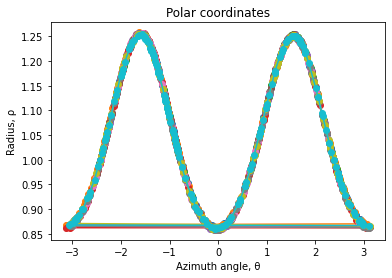

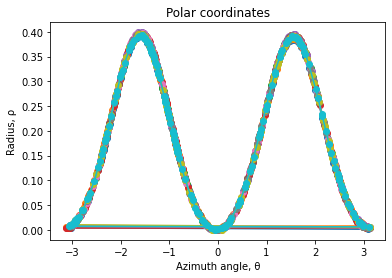

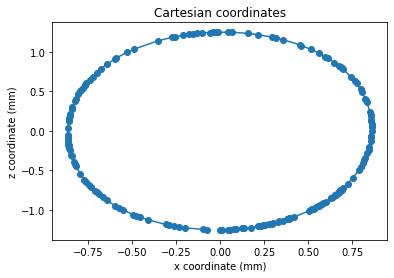

In [110]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#Check that the drop contour is still well defined!

# For 150 contour datapoints:
# plt.figure()
# plt.plot(dataset.iloc[600, 150:300], dataset.iloc[600, 0:150])


# For 175 contour datapoints:
n=80

plt.figure()
plt.title('Polar coordinates')
for n in range(10):
  plt.plot(dataset.iloc[n, 175:350], dataset.iloc[n, 0:175], '-o')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')


plt.figure()
plt.title('Polar coordinates')
for n in range(10):
  plt.plot(dataset.iloc[n, 175:350], dataset.iloc[n, 0:175]-min(dataset.iloc[n, 0:175]), '-o')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')

x, y=pol2cart(dataset.iloc[n, 0:175].values, dataset.iloc[n, 175:350].values)

plt.figure()
plt.title('Cartesian coordinates')
plt.plot(x, y, '-o')
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')

print(max(dataset.iloc[n, 0:175])-min(dataset.iloc[n, 0:175]))

####Check data distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Shape of new dataset (10041, 353)


,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
10036,0.728844,0.728643,0.727055,0.727860,0.724637,0.720080,0.712564,0.705134,0.700617,0.693777,0.688166,0.687464,0.665799,0.649110,0.643974,0.639940,0.622205,0.620156,0.616038,0.608271,0.606561,0.602179,0.598402,0.597570,0.591542,0.590799,0.588914,0.584501,0.584751,0.582118,0.584426,0.583674,0.583449,0.583298,0.583674,0.582897,0.584250,0.583223,0.583599,0.585826,...,-0.993103,-1.001002,-1.070778,-1.078371,-1.090880,-1.098410,-1.125780,-1.133165,-1.140511,-1.152852,-1.167347,-1.211067,-1.218075,-1.237060,-1.242185,-1.296548,-1.308298,-1.330360,-1.336806,-1.370276,-1.375486,-1.380708,-1.397355,-1.403475,-1.413919,-1.425168,-1.430393,-1.446768,-1.462469,-1.473479,-1.478709,-1.483944,-1.494428,-1.505273,-1.541933,-1.547179,-1.562922,1.293149,8.92,38.072642
10037,0.728176,0.729631,0.725408,0.725015,0.718020,0.716245,0.710451,0.704662,0.699912,0.696224,0.691416,0.672419,0.662136,0.652084,0.649104,0.633789,0.627386,0.620587,0.617929,0.611527,0.607302,0.605650,0.598762,0.598102,0.593893,0.592795,0.590929,0.588113,0.584807,0.582602,0.582903,0.582187,0.581697,0.581433,0.582639,0.583116,0.584807,0.585420,0.587216,0.588436,...,-1.020631,-1.036202,-1.043942,-1.071899,-1.079518,-1.087101,-1.102161,-1.114630,-1.129478,-1.163738,-1.168799,-1.188251,-1.195371,-1.250761,-1.262744,-1.286571,-1.293235,-1.327118,-1.332328,-1.338787,-1.355602,-1.360823,-1.372356,-1.383817,-1.389041,-1.405648,-1.422168,-1.432645,-1.437895,-1.443824,-1.454305,-1.464812,-1.502121,-1.507722,-1.523463,-1.549747,-1.555008,1.289994,8.92,38.069926
10038,0.731876,0.733274,0.728952,0.728480,0.721265,0.719345,0.713372,0.707462,0.706064,0.698764,0.697255,0.675190,0.659737,0.653398,0.647821,0.628845,0.625836,0.620071,0.614311,0.610980,0.605532,0.604141,0.598448,0.598533,0.593329,0.589246,0.587282,0.586235,0.582329,0.584009,0.582693,0.581599,0.580731,0.579584,0.580995,0.582693,0.581763,0.582479,0.583558,0.585560,...,-1.015219,-1.030864,-1.038641,-1.069431,-1.077045,-1.084624,-1.097137,-1.112130,-1.124582,-1.159018,-1.166266,-1.185707,-1.192828,-1.248189,-1.260166,-1.283985,-1.290653,-1.324518,-1.330996,-1.336187,-1.352995,-1.358211,-1.369745,-1.381209,-1.386428,-1.403033,-1.419554,-1.430761,-1.435981,-1.441207,-1.451682,-1.462753,-1.499863,-1.505102,-1.521099,-1.547240,-1.552474,1.291805,8.92,38.071487
10039,0.734679,0.732376,0.731806,0.728480,0.724361,0.724068,0.719782,0.709557,0.700719,0.692328,0.689819,0.678949,0.673856,0.672095,0.642663,0.633723,0.629902,0.615904,0.609865,0.603826,0.597494,0.594142,0.590994,0.586596,0.587257,0.581851,0.582479,0.580706,0.577472,0.576267,0.575760,0.575696,0.576102,0.576674,0.577472,0.578889,0.579142,0.582693,0.582592,0.588464,...,-0.978825,-1.018212,-1.056877,-1.064515,-1.072119,-1.141660,-1.146683,-1.161217,-1.168422,-1.192828,-1.199905,-1.206938,-1.231053,-1.243058,-1.273680,-1.278824,-1.297273,-1.302430,-1.354142,-1.364533,-1.387397,-1.392599,-1.425550,-1.430761,-1.435981,-1.452306,-1.457527,-1.468523,-1.478950,-1.484172,-1.499863,-1.515878,-1.526323,-1.531549,-1.536778,-1.547240,-1.557776,1.299788,8.92,38.078337
10040,0.732488,0.727558,0.729466,0.725988,0.726149,0.716903,0.712420,0.707785,0.702744,0.695335,0.689143,0.688166,0.664568,0.649245,0.643746,0.639254,0.620274,0.617935,0.613325,0.608535,0.602981,0.598280,0.597717,0.592950,0.590254,0.589287,0.586849,0.582118,0.582043,0.579094,0.5

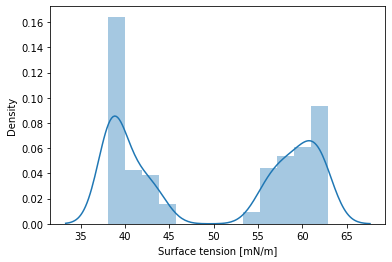

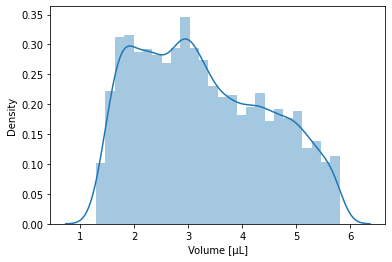

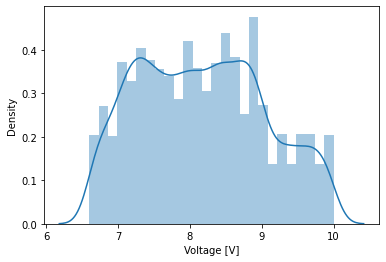

In [111]:
# dataset = dataset[(dataset['volume'] >= 1) & (dataset['volume'] <= 5)]
# dataset = dataset[(dataset['st'] >= 45) & (dataset['st'] <= 65)]
# dataset = dataset[(dataset['volt'] >= 6.5) & (dataset['volt'] <= 8.5)]
# # dataset = dataset[(dataset['Aspect_Ratio'] <= 1.5)]


# plt.figure()
# plt.scatter(dataset.loc[:, 'Aspect_Ratio'], dataset.loc[:, 'centre_y'])
# plt.xlabel('Aspect Ratio')
# plt.ylabel('Position on z-axis [mm]')

plt.figure()
plt.ylabel('Density')
sns.distplot(dataset.loc[:, 'ST'])
plt.xlabel('Surface tension [mN/m]')

plt.figure()
plt.ylabel('Density')
sns.distplot(dataset.loc[:, 'volume'])
plt.xlabel('Volume [μL]')

plt.figure()
plt.ylabel('Density')
sns.distplot(dataset.loc[:, 'volt'])
plt.xlabel('Voltage [V]')

# plt.figure()
# plt.ylabel('Density')
# sns.distplot(dataset.loc[:, 'Aspect_Ratio'])
# plt.xlabel('Aspect Ratio')

print('Shape of new dataset', dataset.shape)
dataset.tail()


#### Calculate the acoustic pressure from the simple model

In [15]:
new_input=np.asarray(dataset)

In [ ]:
# dataset.iloc[:, 604]

In [16]:
# # If no contour points were droped
n_ST=603
n_Rsph=601
rho_i=0
rho_f=300
theta_i=300
theta_f=600

Min:  1730.1013100049177 Pa, Max: 2951.0681793122603 Pa


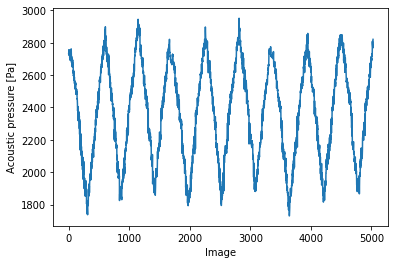

In [17]:
from lmfit import Model, fit_report, Parameters

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
    rho=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)+R_sph
    return rho


data_Ps=[]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340 #mm^-1

for i in range(len(new_input)):
  gamma=new_input[i, n_ST]
  R_sph=new_input[i, n_Rsph]
  rho=new_input[i, rho_i:rho_f]
  gmodel = Model(model_fit, nan_policy='omit')
    
  fit_param = Parameters()
  fit_param.add('Ps', value=700, min=10, max=4000)
  
  result = gmodel.fit(rho, th=new_input[i, theta_i:theta_f], params=fit_param)         #rho_final, th: x and y to be evaluated, respectively
  Ps=result.params['Ps'].value
  data_Ps.append(Ps)
data_Ps=np.asarray(data_Ps)

plt.figure()
plt.plot(data_Ps)
plt.xlabel('Image')
plt.ylabel('Acoustic pressure [Pa]')

print('Min: ', min(data_Ps), 'Pa, Max:', max(data_Ps), 'Pa')

In [18]:
dataset['Ps']=data_Ps

dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,R_sph,volt,ST,Ps
5024,0.996002,0.996046,0.996528,0.993154,0.993330,0.993945,0.990129,0.989533,0.985300,0.985906,0.986526,0.978083,0.976959,0.973225,0.971832,0.969214,0.966061,0.961180,0.958905,0.955603,0.946831,0.942322,0.932738,0.932668,0.925992,0.921286,0.919775,0.916841,0.908753,0.906298,0.874911,0.871426,0.867565,0.861045,0.848694,0.848652,0.845945,0.826792,0.809850,0.794877,...,-0.925558,-0.972699,-0.978642,-0.990486,-1.002272,-1.010401,-1.016232,-1.022047,-1.039392,-1.067953,-1.073611,-1.090468,-1.101609,-1.112668,-1.143662,-1.163504,-1.174138,-1.192165,-1.216717,-1.248416,-1.266015,-1.360792,-1.373019,-1.380661,-1.385210,-1.421524,-1.448837,-1.484141,-1.495649,-1.503590,-1.526594,-1.534274,-1.538241,-1.545897,-1.565049,3.088455,0.903409,9.9,54.707306,2769.294762
5025,0.996002,0.996046,0.996148,0.996806,0.997331,0.997536,0.994429,0.990967,0.990577,0.986526,0.987161,0.987810,0.979794,0.978761,0.975153,0.970280,0.971360,0.964802,0.963616,0.957879,0.954696,0.946285,0.941943,0.932668,0.929273,0.926189,0.921626,0.920163,0.917326,0.907510,0.905116,0.874370,0.870933,0.867154,0.860732,0.848652,0.848643,0.845953,0.827223,0.810704,...,-0.910710,-0.940253,-0.986926,-0.992817,-1.004555,-1.016232,-1.027845,-1.033627,-1.035774,-1.052946,-1.081205,-1.086800,-1.101609,-1.112668,-1.123646,-1.154429,-1.174138,-1.183158,-1.202612,-1.225618,-1.258450,-1.275931,-1.369207,-1.381395,-1.389030,-1.393542,-1.429716,-1.456950,-1.492113,-1.503590,-1.511251,-1.534414,-1.542069,-1.545897,-1.553557,3.090955,0.903652,9.9,54.719205,2767.431095
5026,0.996183,0.996468,0.996592,0.997052,0.992602,0.991633,0.990847,0.991398,0.988191,0.982694,0.981389,0.981114,0.975644,0.976636,0.969355,0.967964,0.965403,0.961875,0.952404,0.947567,0.940843,0.937152,0.933516,0.928495,0.926878,0.923731,0.914987,0.912309,0.880914,0.877278,0.873160,0.868804,0.855733,0.852963,0.852843,0.832520,0.814367,0.798147,0.790585,0.787642,...,-0.962534,-0.974470,-0.986352,-0.994600,-1.000481,-1.006346,-1.023850,-1.049053,-1.054762,-1.071782,-1.083035,-1.094210,-1.125495,-1.145521,-1.156289,-1.176005,-1.200737,-1.232612,-1.251558,-1.346628,-1.358887,-1.367303,-1.371112,-1.407556,-1.435442,-1.470745,-1.482564,-1.490202,-1.513388,-1.521029,-1.524852,-1.532501,-1.551642,-1.559303,-1.566965,3.091226,0.903679,9.9,54.720491,2791.080375
5027,0.998056,0.998318,0.998435,0.998873,0.998129,0.993302,0.992466,0.993009,0.993566,0.987907,0.982838,0.982527,0.980687,0.977981,0.974281,0.972860,0.970237,0.966658,0.957029,0.955643,0.945255,0.944978,0.937800,0.936106,0.934456,0.931240,0.922283,0.919532,0.887293,0.883592,0.879363,0.874847,0.861393,0.858599,0.858430,0.837478,0.818661,0.801747,0.793880,0.790700,...,-0.955610,-0.964155,-0.976195,-0.984585,-0.990546,-0.996491,-1.014237,-1.039824,-1.045615,-1.062880,-1.074297,-1.085637,-1.119174,-1.139396,-1.150281,-1.170194,-1.195183,-1.228718,-1.246511,-1.343410,-1.355737,-1.364206,-1.368033,-1.404688,-1.433268,-1.468639,-1.480136,-1.488133,-1.511365,-1.519019,-1.522848,-1.530511,-1.549767,-1.557413,-1.565060,3.079225,0.902508,9.9,54.663320,2809.967070
5028,0.996117,0.996358,0.996468,0.996884,0.996058,0.994976,0.994090,0.990847,0.991398,0.985653,0.984293,0.983945,0.978357,0.979331,0.971906,0.974121,0.967829,0.967844,0.958113,0.953153,0.946206,0.942443,0.938673,0.933540,0.931885,0.928660,0.922990,0.918284,0.885342,0.883926,0.879657,0.875084,0.8614

#### Generate contours based on experimental data

0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

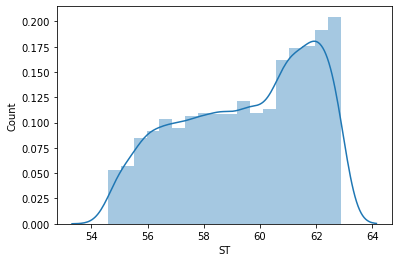

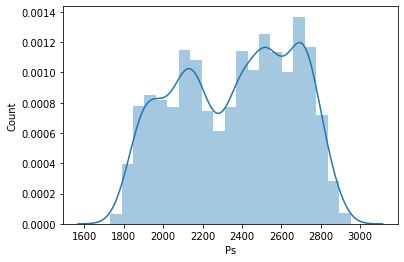

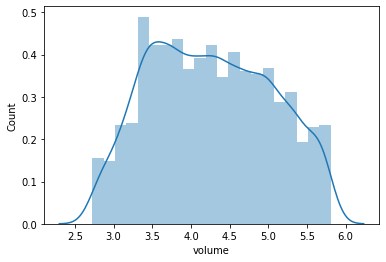

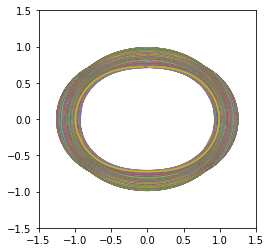

In [19]:
def gen_data(num_sample,sampling, vol, R_sph, Ps, st):
 
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 

    theta=np.random.rand(num_sample, sampling)*np.pi*2
    theta.sort()
    
    # ST_range=np.random.random(num_sample)*(72.4-37)+37
    r_all=np.empty([0,sampling])


    for i in range(num_sample):
        r=R_predict(theta[i], st[i], R_sph[i], Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
        if i % 10000 == 0:
                print(i)
        
    dataset=np.hstack((r_all, theta, vol.values.reshape([num_sample, 1]), Ps.values.reshape([num_sample,1]), st.values.reshape([num_sample,1])))

    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Surface tension [mN/m]')
    sns.distplot(st)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Acoustic pressure [Pa]')
    sns.distplot(Ps)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Volume [μL]')
    sns.distplot(vol)

    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[0:sampling], j[sampling:sampling+sampling])

      plt.plot(x, y)

    plt.show()
    return dataset

num_sample=len(dataset) # number of different ST values
sampling=175 # number of coordiante point describing the contour


gened_data=gen_data(num_sample,sampling, dataset.volume, dataset.R_sph, dataset.Ps, dataset.ST)


column_names=[]
for i in range(sampling):
  column_names.append('rho')
for i in range(sampling):
  column_names.append('theta')
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(gened_data, columns=column_names)




In [20]:
new_dataset=raw_dataset.copy()
new_dataset.pop('Ps')
new_dataset['volt']=dataset.volt
new_dataset.tail()

,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,vol,ST,volt
5024,0.731463,0.731973,0.735343,0.738138,0.738606,0.739459,0.740635,0.742733,0.744784,0.745025,0.745843,0.749210,0.755841,0.763040,0.765428,0.766832,0.766869,0.770754,0.777495,0.782907,0.790578,0.798715,0.806862,0.811318,0.813051,0.817338,0.821498,0.821733,0.831497,0.848264,0.856966,0.857902,0.866838,0.877414,0.881342,0.888038,0.889928,0.892099,0.903560,0.917232,...,4.833458,4.849863,4.859664,4.920185,4.932340,4.946063,5.007012,5.074830,5.107413,5.179471,5.200107,5.237985,5.261847,5.312601,5.334752,5.385089,5.405719,5.446912,5.473949,5.483590,5.587145,5.619014,5.619802,5.660008,5.720633,5.848299,5.865364,5.911026,5.975161,5.979769,6.006083,6.008362,6.160844,6.182630,6.254839,6.272795,6.275814,3.088455,54.707306,9.9
5025,0.732483,0.732982,0.734657,0.735459,0.737505,0.738724,0.739027,0.740238,0.745879,0.747191,0.748327,0.757460,0.759169,0.765397,0.809180,0.814119,0.818123,0.830814,0.832420,0.861523,0.876881,0.885358,0.888072,0.913543,0.914992,0.915201,0.919288,0.920411,0.925679,0.929932,0.930830,0.938749,0.946369,0.948254,0.960040,0.966274,0.979287,0.980627,0.980791,0.980816,...,5.340736,5.348872,5.350989,5.372092,5.397393,5.398235,5.399299,5.448216,5.479824,5.501409,5.570778,5.627144,5.641515,5.673853,5.679527,5.696350,5.821751,5.887643,5.891659,5.894883,5.934875,5.943990,5.952994,5.974957,5.984845,6.032037,6.045282,6.079505,6.112063,6.146986,6.158208,6.181764,6.190843,6.205982,6.216805,6.217015,6.254353,3.090955,54.719205,9.9
5026,0.731824,0.732605,0.735062,0.739380,0.744893,0.748556,0.759738,0.766718,0.775566,0.796146,0.797927,0.801260,0.802032,0.810114,0.818696,0.824205,0.826561,0.833286,0.833358,0.837744,0.845571,0.856573,0.874140,0.879080,0.881087,0.886357,0.886869,0.903694,0.913425,0.930817,0.933402,0.950427,0.962968,0.971961,0.972381,0.977075,0.983737,0.987537,0.990961,0.991020,...,4.893193,4.908007,4.920174,4.936341,4.993369,5.014270,5.076984,5.078585,5.113682,5.203416,5.323608,5.325784,5.382874,5.388708,5.410599,5.414477,5.431517,5.471521,5.490888,5.516200,5.526315,5.529425,5.629970,5.679045,5.698687,5.706386,5.794700,5.832208,5.938318,5.980743,5.989057,6.070896,6.093458,6.093979,6.095593,6.209127,6.242258,3.091226,54.720491,9.9
5027,0.725820,0.729525,0.730136,0.736140,0.736863,0.739890,0.755070,0.755544,0.764178,0.767376,0.774367,0.775074,0.775550,0.779979,0.780277,0.787747,0.789307,0.792938,0.794032,0.808183,0.821083,0.827820,0.828995,0.835509,0.838879,0.839682,0.857801,0.859633,0.859778,0.870315,0.890137,0.891271,0.903406,0.926414,0.935651,0.955750,0.957304,0.957945,0.970819,0.971727,...,4.929082,4.932574,4.972130,5.080187,5.095083,5.107062,5.115289,5.139419,5.170913,5.238224,5.311703,5.342511,5.382663,5.420659,5.427983,5.431050,5.471285,5.473473,5.631477,5.737154,5.746316,5.780022,5.830766,5.894974,5.948133,5.990814,6.059096,6.078607,6.081745,6.094516,6.101759,6.133095,6.137746,6.150567,6.201144,6.254663,6.269861,3.079225,54.663320,9.9
5028,0.724379,0.725419,0.728360,0.729870,0.730428,0.734540,0.743682,0.743742,0.752203,0.756681,0.784104,0.784735,0.786388,0.786738,0.787520,0.794647,0.800271,0.812604,0.820439,0.823073,0.828332,0.847026,0.858519,0.866967,0.880169,0.880494,0.891257,0.902033,0.935465,0.938000,0.954625,0.954746,0.958464,0.961296,0.974041,0.976428,0.977018,0.980020,0.981690,0.982010,...,4.846173,4.850988,4.860475,4.880918,4.926494,5.018320,5.128057,5.131767,5.152510,5.171029,5.177432,5.211626,5.266010,5.346517,5.347025,5.496180,5.604004,5.628340,5.649453,5.664251,5.800937,5.831800,5.835697,5.849390,5.854041,5.886224,5.892348,5.896832,5.909303,5.913683,5.952113,5.965405,5.994763,6.130554,6.136265,6.173488,6.199862

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


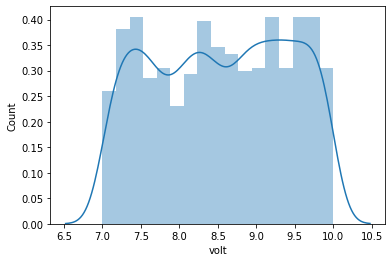

In [23]:
dataset=new_dataset.copy()
dataset.tail()

plt.figure()
plt.ylabel('Count')
plt.xlabel('Voltage [V]')
sns.distplot(dataset.volt)

#### Shuffle dataset

,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,vol,ST,volt
4931,0.773748,0.774065,0.774482,0.776477,0.777515,0.784846,0.795159,0.798180,0.813330,0.813814,0.830793,0.834590,0.855616,0.860508,0.865959,0.867026,0.868480,0.882793,0.885272,0.893750,0.901507,0.912712,0.927132,0.934414,0.946141,0.947815,0.957536,0.958306,0.972130,0.974564,0.975895,0.978765,0.979709,0.981581,0.983039,0.984023,0.984741,0.987215,0.987766,0.988027,...,5.076401,5.133892,5.217354,5.221086,5.351322,5.401862,5.419208,5.432227,5.446930,5.454846,5.503186,5.519323,5.533212,5.541858,5.665780,5.676069,5.676557,5.704639,5.710282,5.720701,5.770309,5.870410,5.876326,5.974415,5.982588,5.985102,6.009609,6.053669,6.058344,6.090725,6.096501,6.143343,6.180862,6.240336,6.275780,6.277851,6.282621,3.228705,55.364156,9.03
3264,0.746735,0.747392,0.749892,0.753422,0.755176,0.755768,0.758175,0.761691,0.765018,0.775517,0.778847,0.782830,0.782964,0.804683,0.805543,0.807837,0.808627,0.809026,0.809052,0.814081,0.822618,0.822938,0.822986,0.834914,0.838105,0.840161,0.847005,0.847841,0.853852,0.855170,0.855343,0.857219,0.858420,0.858500,0.877395,0.881066,0.888215,0.889235,0.904488,0.917120,...,4.975285,5.029652,5.063850,5.121428,5.143440,5.277480,5.291551,5.307396,5.309729,5.325363,5.334472,5.412933,5.459085,5.460076,5.486100,5.500991,5.532658,5.557405,5.581584,5.592067,5.673945,5.674517,5.735912,5.752700,5.754760,5.821118,5.823873,5.832457,5.875663,5.898410,5.914195,5.976885,5.982108,6.053242,6.227578,6.227646,6.228735,2.814265,55.050180,9.22
1653,0.745719,0.746747,0.746908,0.747378,0.750154,0.768376,0.773445,0.779023,0.779668,0.788684,0.789472,0.795287,0.799503,0.812198,0.816730,0.822154,0.824328,0.831341,0.838349,0.843634,0.847149,0.870740,0.872849,0.879899,0.889789,0.891846,0.892344,0.899122,0.919840,0.934346,0.939038,0.944948,0.948675,0.961188,0.985578,0.997457,0.998918,1.002099,1.004894,1.005233,...,5.156443,5.200160,5.215754,5.233117,5.248860,5.256218,5.267235,5.290535,5.303452,5.353280,5.365304,5.401391,5.408322,5.543476,5.548784,5.655926,5.698469,5.723780,5.731228,5.758444,5.791406,5.797184,5.821981,5.909975,5.981027,6.013135,6.018526,6.020163,6.030497,6.038473,6.038777,6.041408,6.087274,6.138862,6.153787,6.206432,6.237278,3.331311,55.642448,9.80
2607,0.848055,0.850074,0.851183,0.851646,0.851947,0.852450,0.855375,0.855914,0.859971,0.860530,0.861255,0.861388,0.866610,0.867197,0.906049,0.909520,0.911712,0.914721,0.917272,0.918479,0.925249,0.936888,0.940410,0.946847,0.964059,0.964980,0.965958,0.970232,0.971306,0.972934,0.974322,0.981082,0.994119,0.996341,1.000160,1.003864,1.004881,1.009046,1.011739,1.012737,...,5.099095,5.125101,5.158771,5.194710,5.236770,5.290483,5.291812,5.320974,5.382700,5.386726,5.394585,5.402016,5.454530,5.454746,5.458253,5.466572,5.469286,5.475152,5.535190,5.692108,5.735426,5.748764,5.828857,5.879103,5.916840,5.924746,5.962557,5.999754,6.005290,6.070781,6.117569,6.131588,6.154254,6.177755,6.178850,6.253898,6.279011,3.685182,59.074536,8.26
2732,0.783442,0.784427,0.785171,0.788716,0.788940,0.792200,0.796004,0.802478,0.810032,0.820066,0.834421,0.837643,0.838367,0.852451,0.855788,0.858889,0.866284,0.866596,0.872560,0.879249,0.886640,0.889891,0.903180,0.910763,0.913484,0.937560,0.938503,0.950774,0.957722,0.968886,0.976315,0.979157,0.989193,1.008037,1.010263,1.015072,1.015814,1.018553,1.022676,1.022823,...,5.031950,5.037004,5.084244,5.102063,5.126078,5.131897,5.144514,5.164957,5.180095,5.191703,5.199919,5.218631,5.235040,5.249769,5.304932,5.458366,5.465068,5.652848,5.690225,5.729662,5.753269,5.789910,5.790007,5.813338,5.841148,5.847571,5.869666,5.870468,5.920410,5.941893,5.971870,6.060937,6.087725,6.142960,6.151300,6.174730,6.18

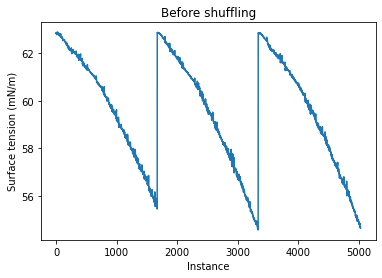

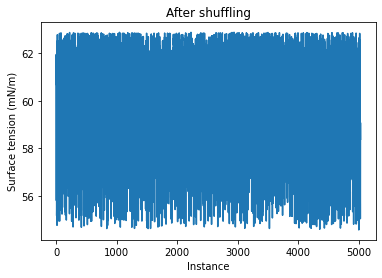

In [24]:
from sklearn.utils import shuffle

plt.figure()
plt.title('Before shuffling')
plt.plot(range(len(dataset)), dataset.ST)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')

dataset=shuffle(dataset, random_state=0)

plt.figure()
plt.title('After shuffling')
plt.plot(range(len(dataset)), dataset.ST)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')

dataset.tail()

###Generate data based on physical model

0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

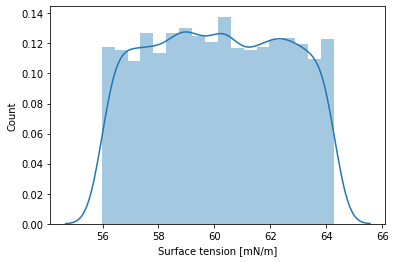

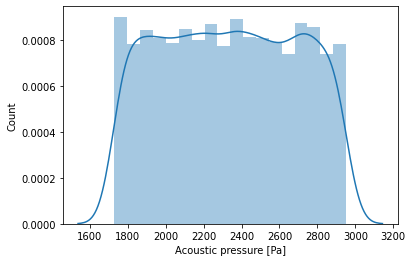

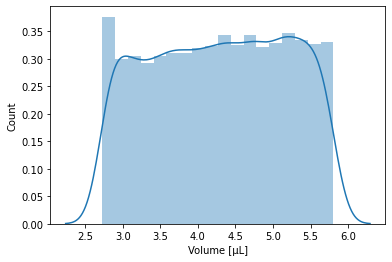

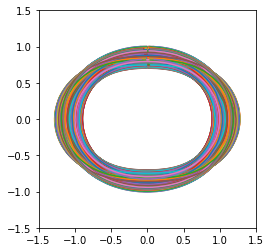

In [5]:
def gen_data(num_sample,sampling):

    #np.random.seed(1234)

    vol_drop=np.random.random(num_sample)*(5.8048770124995-2.72577361977)+2.72577361977 # in µL
    # vol_drop=np.tile(vol_drop, num_sample)   # If the volume is constant !!!

    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 

    Ps=np.random.random(num_sample)*(2951.0681793122603-1730.1013100049177)+1730.1013100049177  #[Pa]
    R_sph=calc_R_sph(vol_drop)

    theta=np.random.rand(num_sample, sampling)*np.pi*2
    theta.sort()
    
    ST_range=np.random.random(num_sample)*(64.26702760889-55.9743789)+55.9743789
    r_all=np.empty([0,sampling])


    for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
        if i % 10000 == 0:
                print(i)
        
    
    dataset=np.hstack((r_all, theta, vol_drop.reshape([num_sample, 1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))

    # print(ST_range.min())
    # print(ST_range.max())

    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Surface tension [mN/m]')
    sns.distplot(ST_range)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Acoustic pressure [Pa]')
    sns.distplot(Ps)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Volume [μL]')
    sns.distplot(vol_drop)

    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[0:sampling], j[sampling:sampling+sampling])

      plt.plot(x, y)

    plt.show()
    return dataset

num_sample=5028 # number of different ST values
sampling=175 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('rho')
for i in range(sampling):
  column_names.append('theta')
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

# raw_dataset.to_csv('./dataset.csv',index=False)


### Check dataset

In [ ]:
#Remove columns

# Ps=raw_dataset.pop('Ps')
# volume=raw_dataset.pop('vol')

In [ ]:

#input = pd.read_csv(io.BytesIO(uploaded['data.csv']))
#input = pd.DataFrame(dataset)
# Dataset is now stored in a Pandas Dataframe
#input.size


(100000, 353)

In [7]:
# loading of data
# raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
# dataset.pop('vol')
dataset.tail()


,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,vol,Ps,ST
5023,0.973571,0.973722,0.975695,0.977025,0.978466,0.982960,0.987002,0.992049,0.992529,0.995775,0.997415,0.997650,0.998202,0.999453,1.004148,1.004768,1.008629,1.009206,1.010956,1.011231,1.012184,1.014630,1.016767,1.019334,1.023196,1.040243,1.042890,1.045321,1.067157,1.081398,1.084037,1.090689,1.096600,1.098053,1.099413,1.100968,1.102156,1.102310,1.106450,1.110081,...,4.960203,4.991198,4.996206,5.042421,5.042763,5.102444,5.128245,5.203499,5.204563,5.221438,5.232064,5.250920,5.290062,5.332872,5.368238,5.415610,5.425856,5.448685,5.477890,5.481254,5.485688,5.544590,5.735145,5.779408,5.849398,5.890043,5.894751,5.904939,5.936544,5.976669,6.102233,6.115729,6.159227,6.174112,6.176478,6.224156,6.232797,5.595628,1947.246254,64.086666
5024,0.828414,0.828694,0.831558,0.831680,0.831853,0.832024,0.832514,0.835365,0.837543,0.837982,0.838223,0.841627,0.846997,0.848149,0.852063,0.855060,0.855721,0.856273,0.897953,0.900582,0.903184,0.905015,0.912427,0.912589,0.917160,0.921329,0.925278,0.931690,0.942561,0.948355,0.948412,0.949963,0.951309,0.953858,0.953918,0.953954,0.956140,0.957579,0.957831,0.958916,...,4.823111,4.833411,4.946374,5.013659,5.066220,5.076292,5.079026,5.279561,5.305197,5.314583,5.323150,5.389210,5.465526,5.499105,5.508488,5.563920,5.587302,5.598259,5.603287,5.655210,5.789738,5.799977,5.812228,5.827841,5.834762,5.874950,5.899682,5.918664,5.938799,5.953316,5.999233,6.045644,6.092455,6.113754,6.128132,6.154740,6.179114,3.239192,2116.515869,62.876994
5025,0.862275,0.863141,0.867354,0.867683,0.870011,0.876418,0.918757,0.923739,0.927322,0.949019,0.967974,0.975240,0.976745,0.986363,0.988947,1.000737,1.032795,1.055504,1.065403,1.085361,1.106451,1.106805,1.140242,1.177591,1.182356,1.184300,1.189314,1.198257,1.200592,1.210005,1.212248,1.216412,1.223872,1.223835,1.223529,1.223331,1.223070,1.222477,1.221497,1.214830,...,4.949121,4.951414,4.959758,5.071131,5.073390,5.184138,5.197204,5.216404,5.286960,5.314043,5.327504,5.328971,5.333605,5.359280,5.375948,5.380732,5.398018,5.438796,5.456976,5.552268,5.571270,5.617187,5.728023,5.750294,5.782926,5.899503,5.903819,6.009401,6.115670,6.136470,6.156051,6.212701,6.229728,6.234822,6.244620,6.253064,6.264880,5.623456,2529.442582,57.618311
5026,0.796106,0.797518,0.797649,0.798982,0.799338,0.802478,0.810697,0.814182,0.815513,0.817840,0.819231,0.827515,0.828699,0.839344,0.842449,0.842461,0.847939,0.860823,0.881214,0.883773,0.892682,0.901411,0.904475,0.916891,0.920725,0.934245,0.945048,0.954599,0.958505,0.974382,0.975060,0.975517,0.983103,0.983865,0.988877,0.990750,0.992064,0.992409,0.992527,0.993312,...,4.868736,4.911523,4.923562,5.013680,5.082398,5.125800,5.144826,5.214002,5.223049,5.238470,5.316983,5.350029,5.377119,5.453743,5.456500,5.525875,5.533257,5.557273,5.592250,5.599524,5.602729,5.634956,5.761490,5.793488,5.861547,5.922259,5.930272,5.944415,5.952277,5.977253,6.003509,6.010027,6.039417,6.070830,6.150813,6.157882,6.267816,3.369504,2498.424085,61.973985
5027,0.969205,0.969279,0.969542,0.969549,0.969978,0.971453,0.971884,0.973020,0.978126,0.978322,0.982792,0.989463,1.004818,1.013130,1.016983,1.024525,1.028837,1.029715,1.032958,1.042319,1.046351,1.046988,1.053014,1.054783,1.058143,1.059887,1.069235,1.085363,1.088874,1.090054,1.091122,1.091505,1.093516,1.098894,1.101532,1.106017,1.106612,1.111026,1.114704,1.125190,...,5.159165,5.201359,5.216485,5.230640,5.235338,5.291359,5.302868,5.329298,5.336906,5.418787,5.448361,5.450154,5.492535,5.530718,5.583279,5.598826,5.678685,5.731718,5.736129,5.776097,5.778668,5.799145,5.805565,5.882466,5.886511,5.892089,5.908063,5.963738,5.969467,5.995275,6.007997,6.101311,6.168137,6.171

### Check contours

Text(0, 0.5, 'z coordinate (mm)')

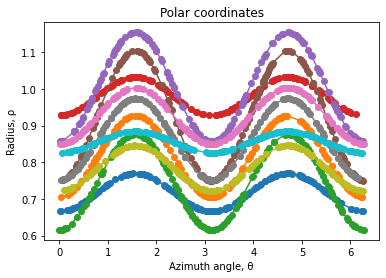

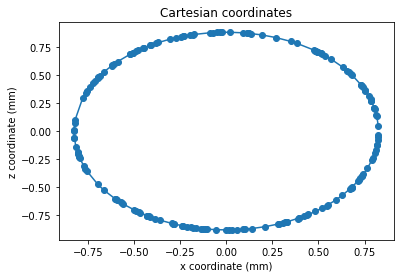

In [6]:

n=0

plt.figure()
plt.title('Polar coordinates')
for n in range(10):
  plt.plot(dataset.iloc[n, 175:350], dataset.iloc[n, 0:175], '-o')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')


x, y=pol2cart(dataset.iloc[n, 0:175].values, dataset.iloc[n, 175:350].values)


plt.figure()
plt.title('Cartesian coordinates')
plt.plot(x, y, '-o')
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')



### Adding noise 



#### To acoustic pressure

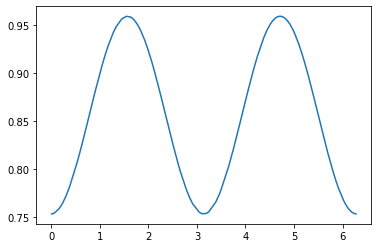

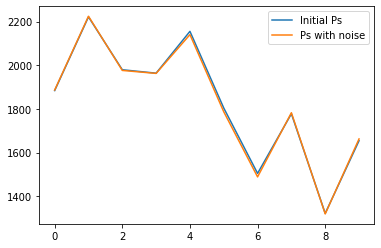

In [ ]:
noisy_dataset=dataset.copy()

np.random.seed(seed=1)
noise1 = np.random.random(size=[len(dataset), ])*25
noise2=np.random.random(size=[len(dataset), ])*25
noisy_dataset.Ps=noisy_dataset.Ps+noise1-noise2

plt.figure()
plt.plot(dataset.iloc[0, 0:sampling], dataset.iloc[0, sampling:sampling*2])

plt.figure()
plt.plot(dataset.Ps[0:10], label='Initial Ps')
plt.plot(noisy_dataset.Ps[0:10], label='Ps with noise')
plt.legend()

#### To ST

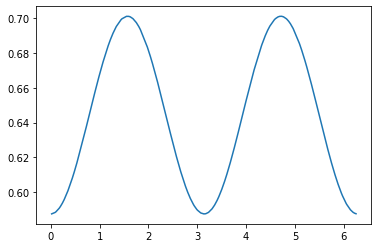

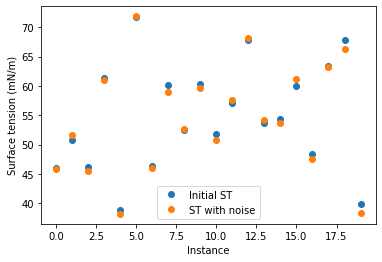

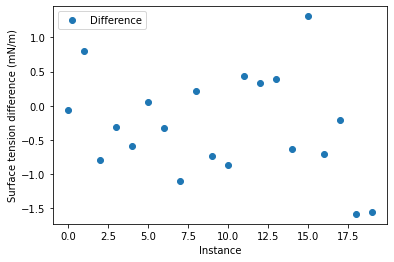

In [ ]:
noisy_dataset=dataset.copy()

np.random.seed(seed=1)
noise1 = np.random.random(size=[len(dataset), ])*2
noise2=np.random.random(size=[len(dataset), ])*2
noisy_dataset.ST=noisy_dataset.ST+noise1-noise2

plt.figure()
plt.plot(dataset.iloc[0, sampling:sampling*2], dataset.iloc[0, 0:sampling])

plt.figure()
plt.plot(dataset.ST[0:20], 'o', label='Initial ST')
plt.plot(noisy_dataset.ST[0:20], 'o', label='ST with noise')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
plt.legend()

plt.figure()
plt.plot(noisy_dataset.ST[0:20]-dataset.ST[0:20], 'o', label='Difference')
plt.xlabel('Instance')
plt.ylabel('Surface tension difference (mN/m)')
plt.legend()

### Save the noise dataset

In [ ]:
#The original dataset is on: raw_dataset.tail()
# dataset=raw_dataset
#Save the noisy dataset as dataset
dataset=noisy_dataset.copy()
dataset.tail()

,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,vol,Ps,ST
49995,0.769955,0.770697,0.771015,0.776379,0.782352,0.784597,0.786373,0.788958,0.789436,0.805315,0.827363,0.828521,0.831590,0.833441,0.844612,0.845183,0.886958,0.886974,0.888134,0.889240,0.897181,0.905043,0.910937,0.920526,0.935758,0.963128,0.977860,0.986319,0.991945,0.997989,1.005684,1.007431,1.010972,1.019495,1.033733,1.076026,1.082972,1.091499,1.095921,1.098607,...,5.233004,5.242322,5.322742,5.333836,5.358181,5.373785,5.403396,5.437367,5.452760,5.470141,5.474240,5.484448,5.505969,5.577914,5.618597,5.644451,5.701744,5.702784,5.721982,5.730067,5.758448,5.803562,5.846485,5.862451,5.874571,5.888006,5.932525,5.948961,5.951301,6.035272,6.038860,6.085891,6.102256,6.108532,6.219703,6.253468,6.269021,4.122496,2949.759108,61.338048
49996,0.910290,0.910332,0.910342,0.910568,0.912532,0.913510,0.914056,0.915070,0.915496,0.920794,0.922659,0.931632,0.934234,0.935204,0.938501,0.940863,0.947361,0.949331,0.949404,0.967056,0.971981,0.972188,0.976915,0.997527,0.997569,0.999382,1.002583,1.030621,1.032040,1.034725,1.038209,1.040127,1.042091,1.042372,1.046991,1.050937,1.054166,1.056911,1.057223,1.057570,...,4.910898,4.996901,5.022119,5.169784,5.179328,5.242008,5.454634,5.459680,5.460495,5.502913,5.597333,5.659587,5.729177,5.776700,5.790093,5.803805,5.852164,5.886311,5.888862,5.899767,5.930305,5.936660,5.940499,5.999136,6.007672,6.032659,6.057659,6.062430,6.067571,6.152387,6.157602,6.161447,6.169635,6.183506,6.229720,6.263364,6.270704,4.304270,1743.073514,50.960358
49997,0.586644,0.586776,0.586795,0.586901,0.587003,0.587587,0.591613,0.594711,0.597562,0.603858,0.605395,0.610209,0.620001,0.625687,0.626209,0.636987,0.640421,0.642318,0.646872,0.648170,0.650649,0.658559,0.661689,0.661790,0.666491,0.668950,0.670898,0.670932,0.672066,0.678887,0.685104,0.687331,0.688200,0.688923,0.691293,0.696127,0.696388,0.698145,0.701267,0.701424,...,5.108276,5.127739,5.227892,5.257026,5.270807,5.303375,5.332903,5.366171,5.405994,5.407792,5.409818,5.413021,5.451912,5.519271,5.543495,5.543712,5.566138,5.672679,5.689355,5.691150,5.694272,5.711496,5.721450,5.770779,5.787785,5.832358,5.842174,5.951822,5.955853,5.989454,6.056776,6.075804,6.086306,6.091723,6.149270,6.158542,6.278975,1.236705,2652.605001,48.681920
49998,0.644898,0.646495,0.648373,0.649100,0.651215,0.651268,0.651305,0.651601,0.651936,0.653408,0.654607,0.655012,0.655019,0.657257,0.659747,0.660921,0.663111,0.663552,0.664577,0.665603,0.665701,0.668933,0.670990,0.673819,0.673942,0.674585,0.674749,0.675051,0.677482,0.677718,0.678418,0.680482,0.681092,0.681226,0.682003,0.682094,0.682816,0.683787,0.683792,0.684316,...,4.791252,4.806562,4.933062,5.015943,5.020122,5.128187,5.135035,5.156354,5.166225,5.212851,5.227481,5.240392,5.245343,5.322665,5.343934,5.422659,5.493397,5.511559,5.512171,5.525491,5.591924,5.597788,5.604130,5.622519,5.783490,5.796063,5.867751,5.890577,5.895930,6.027386,6.031562,6.039119,6.111923,6.164214,6.197428,6.205821,6.229579,1.267398,1603.639302,53.421673
49999,0.592004,0.593309,0.593520,0.594089,0.594366,0.594452,0.595602,0.599017,0.600305,0.602857,0.603192,0.604647,0.606356,0.609111,0.611722,0.612152,0.618323,0.623819,0.626364,0.632660,0.637612,0.640900,0.645028,0.646308,0.649565,0.660481,0.668609,0.668941,0.670443,0.670822,0.672936,0.676517,0.677665,0.679043,0.679055,0.680717,0.680768,0.681716,0.682287,0.682819,...,4.758974,4.808215,4.853784,4.900183,4.901307,4.925324,4.996934,5.084057,5.118733,5.126677,5.204361,5.255058,5.285198,5.319554,5.342053,5.373407,5.553076,5.560371,5.564270,5.577858,5.579047,5.655629,5.670338,5.803566,5.946857,5.996128,6.030702,6.035705,6.052609,6.120562,6.128383,6.158242,6.169614,

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("ST")
train_stats = train_stats.transpose()
train_stats.tail()

,count,mean,std,min,25%,50%,75%,max
theta,4022.0,6.175874,0.060769,5.838744,6.142121,6.187693,6.220974,6.278876
theta,4022.0,6.212079,0.049802,5.910422,6.187772,6.223620,6.248540,6.282660
theta,4022.0,6.247587,0.035244,5.982802,6.234234,6.258223,6.272689,6.283175
vol,4022.0,4.282177,0.888784,2.726684,3.530718,4.300698,5.059294,5.804776
Ps,4022.0,2336.100094,352.587641,1730.663702,2028.703415,2338.025842,2641.371877,2950.758412


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [10]:
train_labels = train_dataset.pop('ST')
test_labels = test_dataset.pop('ST')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

### Min-Max transformation

In [11]:
def min_max_norm(x):
  return (x-train_stats['min'])/(train_stats['max']-train_stats['min'])

normed_train_data = min_max_norm(train_dataset)
normed_test_data  = min_max_norm(test_dataset)


Text(0.5, 0, 'Azimuth angle, θ')

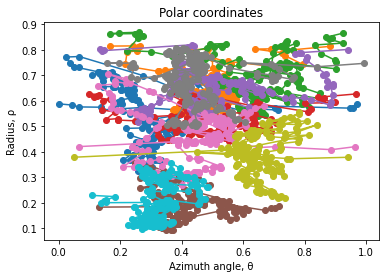

In [12]:
plt.figure()
plt.title('Polar coordinates')
for n in range(10):
  plt.plot(normed_train_data.iloc[n, 175:350], normed_train_data.iloc[n, 0:175], '-o')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')

### Standard normalization

In [ ]:
def std_norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = std_norm(train_dataset)
normed_test_data  = std_norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

####Learning Schedule
The code bellow sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

In [55]:
#Lr_schedule = learning schedule : Most models learn better if you gradually decrase the learning rate.

STEPS_PER_EPOCH=len(train_dataset)/500
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)


Here we can plot the learning rate Vs the number of epocs

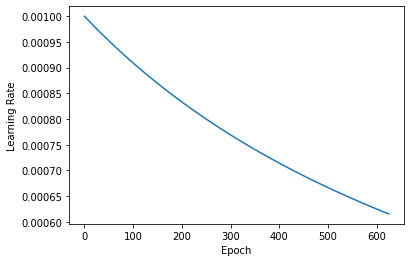

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure()
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

####Define model

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(40, activation=tf.nn.softplus, input_shape=[len(train_dataset.keys())]), #kernel_regularizer='l2', 
    # layers.Dense(50, activation=tf.nn.softplus, kernel_regularizer='l2'),
    layers.Dense(20, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()

In [33]:
model = build_model()

#### If there is a model saved on google drive execute the next block

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.models import load_model

# del model 

folder=str('theoretical_all_vary/')

model_name=str('CNN_model_all_vary_with_Ps_noise_Ps_1200_2300_2_5μL_25_72mN_m_no_noise_only_contours_1.h5')

model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+folder+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [119]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 40)                14120     
_________________________________________________________________
dense_13 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 14,961
Trainable params: 14,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.get_config()

In [ ]:
model.get_weights()


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [120]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-2.3531456],
       [-2.4667268],
       [-2.4129672],
       [-2.4047267],
       [-2.4564786],
       [-2.3870363],
       [-2.4540958],
       [-2.4081466],
       [-2.3806884],
       [-2.5865192]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [34]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
379,0.174035,0.331921,0.174035,0.322604,0.464483,0.322604,379
380,0.154360,0.308597,0.154360,0.243880,0.392239,0.243880,380
381,0.213567,0.361543,0.213567,0.383086,0.513794,0.383086,381
382,0.247532,0.398465,0.247532,0.233762,0.374097,0.233762,382
383,0.148915,0.301172,0.148915,0.134801,0.289448,0.134801,383


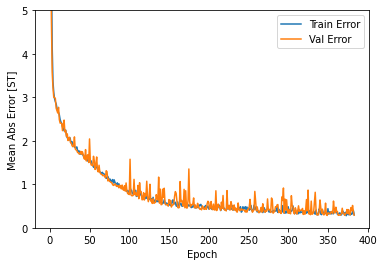

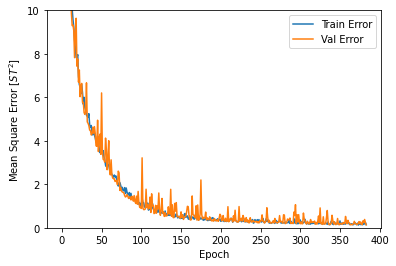

In [36]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [37]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

print("Testing set Mean Abs Error over ST range: {:5.2f}".format(mae/(max(dataset.ST)-min(dataset.ST))))


Testing set Mean Abs Error:  0.29 mN/m
Testing set Mean Abs Error over ST range:  0.03


### Make predictions

Finally, predict ST values using data in the testing set:

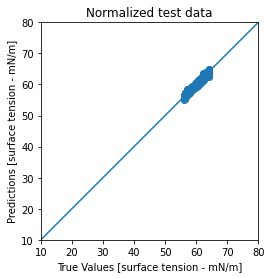

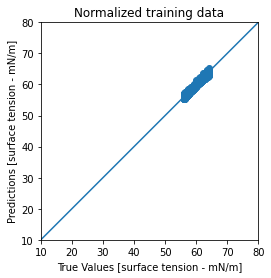

In [38]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

# plt.figure()
# plt.xlabel('Image')
# plt.ylabel('Surface tension [ mN/m ]')
# plt.ylim(30, 75)
# plt.plot(test_predictions[0:2000], label='Predicted test instances')
# plt.plot(range(len(test_labels)-18000), test_labels[0:2000], '--', label='Real test instances')
# plt.legend()


Seriously?

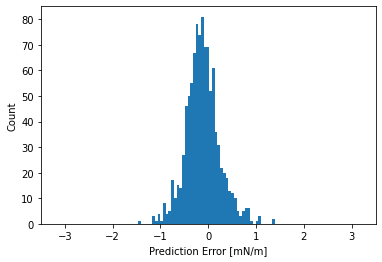

In [39]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
plt.xlim(-3.5, 3.5)
# plt.ylim(0, 10)
plt.show()

Text(0, 0.5, 'Surface tension (mN/m)')

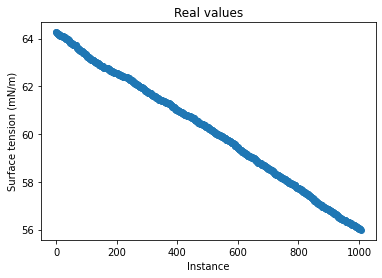

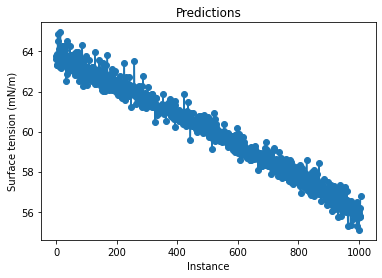

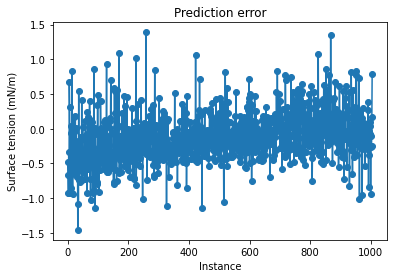

In [40]:

check_test_df=pd.DataFrame(data={'True_values': test_labels, 'Predictions': test_predictions})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

plt.figure()
plt.title('Real values')
plt.plot(range(len(sorted_st)), sorted_st.True_values, '-o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Predictions')
plt.plot(range(len(sorted_st)), sorted_st.Predictions, '-o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Prediction error')
plt.plot(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values, '-o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

# sorted_st

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
folder=str('theoretical_all_vary/')
filename=str('model_all_vary_Ps_1568_3177_1_5μL_37_72.4mNm_MSE_0_18_great_error_distr.h5')
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

### Try out a different model

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(200, activation=tf.nn.softplus, input_shape=[len(train_dataset.keys())]),
    layers.Dense(100, activation=tf.nn.swish), # input_shape=[len(train_dataset.keys())]),
    layers.Dense(50, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
model_big = build_model()

## If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 

model_name=str('test_training_whole_drop_3μL_best_175points_noise_0.004_vol_6.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model_big.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               70200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 95,611
Trainable params: 95,611
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model_big.predict(example_batch)
example_result

array([[0.4646791 ],
       [0.46449545],
       [0.44632238],
       [0.4460677 ],
       [0.4428678 ],
       [0.46233898],
       [0.44848484],
       [0.48535466],
       [0.44410846],
       [0.50217676]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, min_delta=0)

history_big = model_big.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
.............................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist_big = pd.DataFrame(history_big.history)
hist_big['epoch'] = history_big.epoch
hist_big.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
124,109.842056,8.555373,109.842056,110.820740,8.603889,110.820740,124
125,109.929482,8.557758,109.929482,111.271721,8.649287,111.271721,125
126,109.859123,8.554682,109.859123,111.351135,8.592625,111.351135,126
127,109.711716,8.549767,109.711716,111.419083,8.663173,111.419083,127
128,109.710609,8.545816,109.710609,111.692207,8.661056,111.692207,128


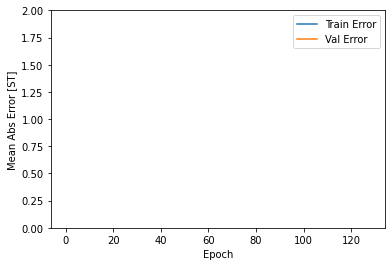

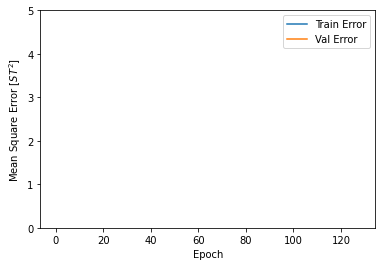

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history_big)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model_big.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  8.67 mN/m


### Make predictions

Finally, predict ST values using data in the testing set:

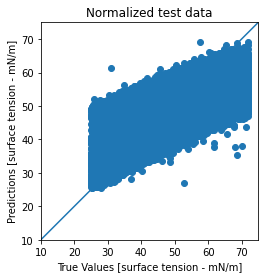

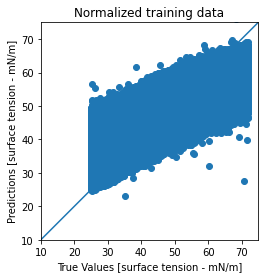

In [ ]:
test_predictions_big = model_big.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions_big)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2_big = model_big.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2_big)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

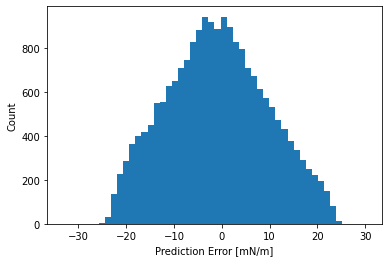

In [ ]:
error_big = test_predictions_big - test_labels
plt.hist(error_big, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 5)
plt.show()

### Trying model No 3


In [ ]:
# def build_model():
#   model = keras.Sequential([
#     #layers.Dense(100, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
#     layers.Conv3D(64, kernel_size=(5,5, 5), strides=(1, 1, 1), activation=tf.nn.swish, input_shape=[len(train_dataset.keys())]),
#     layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1)),
#     layers.Conv3D(32, kernel_size=(5, 5, 5), strides=(1, 1, 1), activation=tf.nn.swish),
#     layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1)),
#     layers.Flatten(),
#     layers.Dense(14, activation=tf.nn.swish),
#     layers.Dense(5, activation=tf.nn.swish),
#     layers.Dense(1)
#   ])

#   optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
#   model.compile(loss='mean_squared_error',
#                 optimizer=optimizer,
#                 metrics=['mean_absolute_error', 'mean_squared_error'])
#   return model

#### Reshape the data

In [ ]:
print(normed_train_data.shape)

(80000, 350)


In [ ]:
sample_size = normed_train_data.shape[0] # number of samples in train set
time_steps1  =2 # int(normed_train_data.shape[1]) # number of features in train set
time_steps2 =175 #int(normed_train_data.shape[1]/25)
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = normed_train_data.values.reshape(sample_size, time_steps1, time_steps2, input_dimension)

input_shape=train_data_reshaped.shape
print(input_shape)

(80000, 2, 175, 1)


#### Reshape test data

In [ ]:
test_data_reshaped = normed_test_data.values.reshape(normed_test_data.shape[0], 2, 175, 1) #int(normed_test_data.shape[1]/25)

In [ ]:
def build_model():
  
  n_timesteps = train_data_reshaped.shape[1] #Number of features
  n_features  = train_data_reshaped.shape[2] #Number of output(s)
  dimension=1
  model = keras.Sequential([
    # layers.Input(shape=),
    layers.Conv2D(filters=50, kernel_size=(1, 1), activation="relu", input_shape=(n_timesteps,n_features, dimension)),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=25, kernel_size=(1, 1), activation="relu"),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),
    # layers.GlobalAveragePooling3D(),
    layers.Flatten(),
    # layers.Dense(100, activation=tf.nn.softplus),
    # layers.Dense(50, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

 # optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mean_squared_error',
                optimizer=get_optimizer(),
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
CNN_model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
CNN_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 2, 175, 50)        100       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 2, 175, 50)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 2, 175, 50)        200       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 175, 25)        1275      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 2, 175, 25)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 2, 175, 25)        100       
_________________________________________________________________
flatten_13 (Flatten)         (None, 8750)            


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = train_data_reshaped[:10]
example_result = CNN_model.predict(example_batch)
example_result

array([[28.087883],
       [32.96527 ],
       [44.103367],
       [69.42511 ],
       [51.100143],
       [45.80421 ],
       [56.901924],
       [51.55749 ],
       [65.29247 ],
       [46.492516]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=15, verbose=0, mode='auto')

history_CNN = CNN_model.fit(train_data_reshaped, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list



.............................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist_CNN = pd.DataFrame(history_CNN.history)
hist_CNN['epoch'] = history_CNN.epoch
hist_CNN.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
24,111.828896,8.636181,111.828896,109.931259,8.527595,109.931259,24
25,111.635277,8.627120,111.635277,113.665749,8.749763,113.665749,25
26,111.584976,8.627238,111.584976,110.240440,8.568928,110.240440,26
27,111.479774,8.623121,111.479774,110.773445,8.627024,110.773445,27
28,111.552353,8.625348,111.552353,109.793175,8.562902,109.793175,28


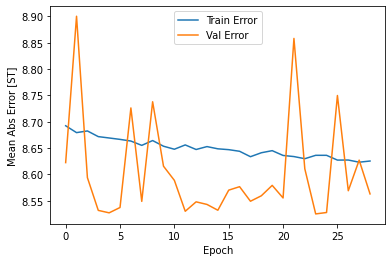

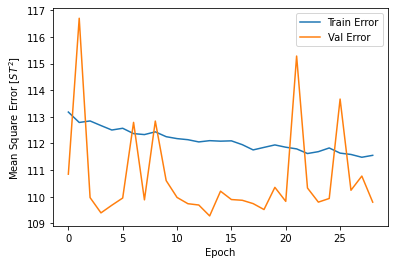

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  # plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history_CNN)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = CNN_model.evaluate(test_data_reshaped, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  8.74 mN/m


### Make predictions

Finally, predict ST values using data in the testing set:

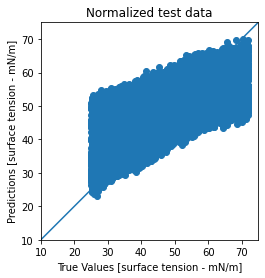

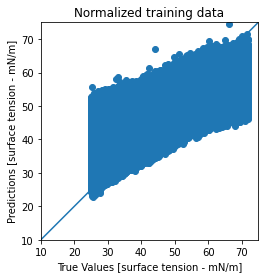

In [ ]:
test_predictions_CNN = CNN_model.predict(test_data_reshaped).flatten()

plt.scatter(test_labels, test_predictions_CNN)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2_CNN = CNN_model.predict(train_data_reshaped).flatten()

plt.scatter(train_labels, test_predictions2_CNN)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

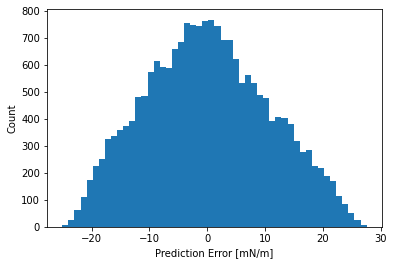

In [ ]:
error_CNN = test_predictions_CNN - test_labels
plt.hist(error_CNN, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 5)
plt.show()

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
folder=str('theoretical_all_vary/')
filename=str('CNN_model_all_vary_with_Ps_noise_Ps_1300_2800_2_6μL_30_70mN_m_no_noise_only_contours_1.h5')
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
CNN_model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

# Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [ ]:
folder=str('theoretical_only_Ps_vary/')
filename=str('test_training_Ps_1800_3000_3μL.h5')

model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)

# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 14)                4928      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 75        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 5,009
Trainable params: 5,009
Non-trainable params: 0
_________________________________________________________________


View the MAE of the saved and re-called model:

In [ ]:
# Evaluation
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))


### Genarate new data and evaluate the saved model

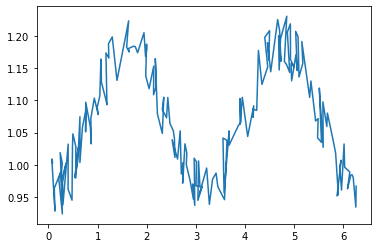

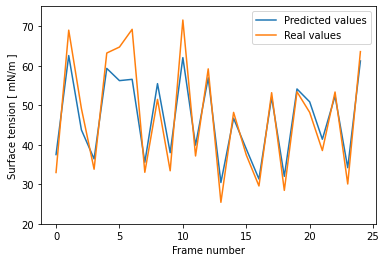

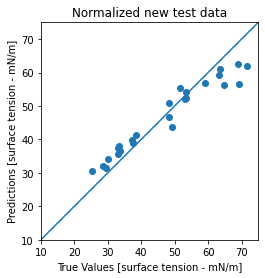

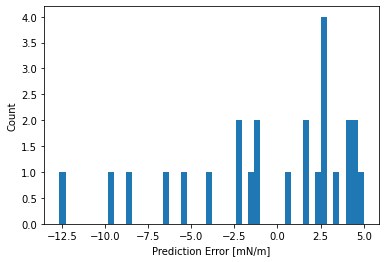

In [ ]:
def norm_test(x):
  return (x - stats_input_df['mean']) / stats_input_df['std']

#import model from drive
#filename=str('test_training_whole_drop_best.h5')
#model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)


num_sample_test=25
sampling=175
vol_drop=np.random.random(num_sample_test)*(7-2)+2
R_sph=calc_R_sph(vol_drop[i], calibration)
Ps=np.random.random(num_sample_test)*(2000-1000)+2000 #Pa
theta_test=np.random.rand(num_sample_test, sampling)*np.pi*2
theta_test.sort()

ST_test=np.random.random(num_sample_test)*(72-25)+25

r_all_test=np.empty([0,sampling])

for i in range(num_sample_test):
  r_test=R_predict(theta_test[i], ST_test[i], R_sph[i], Ps[i], Cg_air, k_o)
  r_all_test=np.vstack((r_all_test, r_test))

test_dataset=np.hstack((theta_test,r_all_test, ST_test.reshape([num_sample_test,1])))

############### Adding noise #############################
noise = np.random.random(size=test_dataset.shape)*0.1
#print(noise)
test_dataset=test_dataset+noise
plt.figure()
plt.plot(test_dataset[0, 0:sampling], test_dataset[0, sampling:sampling*2])
##########################################################

input_array=test_dataset[:, 0:sampling*2]
input_df=pd.DataFrame(input_array, index=None, dtype=float)

stats_input_df=input_df.describe()
stats_input_df=stats_input_df.transpose()

norm_input_array=norm_test(input_df)
prediction=model.predict(norm_input_array).flatten()
true_values=test_dataset[:, sampling*2]

plt.figure()
plt.xlabel('Frame number')
plt.ylabel('Surface tension [ mN/m ]')
plt.ylim(20, 75)
plt.plot(prediction, label='Predicted values')
plt.plot(true_values, label='Real values')
plt.legend()

plt.figure()
plt.scatter(true_values, prediction)
plt.title('Normalized new test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = prediction - true_values
plt.figure()
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
plt.show()
